<AxesSubplot:xlabel='Time'>

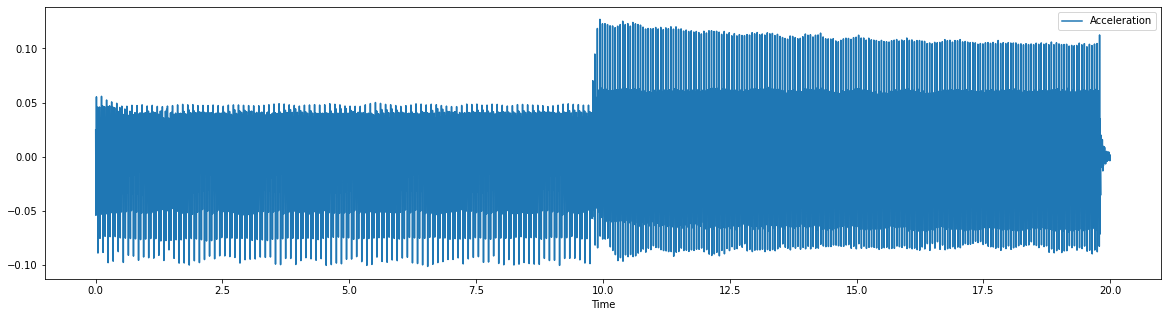

In [1]:
import sys; sys.path.append('..')
import os
from utils.data import read_lvm


dataset = read_lvm(os.path.abspath('../data/Ivol_Acc_Load_data3_w3_w2_50per_STD_downBy256.lvm'))
dataset.plot(y='Acceleration', x='Time', figsize=(20, 5))

In [2]:
from models import OnlineMLP
import numpy as np


forecast_length = 5
mlp = OnlineMLP(10, forecast_length, [10], 1, verbose=True)
preds = np.append(
    np.nan * np.ones(shape=(forecast_length,)),
    np.array([mlp.update(accel) for _, _, accel in dataset.itertuples()])
)

Samples processed: 357

KeyboardInterrupt: 

In [ ]:
period = dataset['Time'].values[-1] / dataset.shape[0]

seen = np.append(dataset['Acceleration'].values, np.nan * np.ones(shape=(forecast_length,)))
index = np.array([i * period for i in range(seen.size)])

results = pd.DataFrame({'Observed': seen, 'Predicted': preds}, index=index)
results.plot(figsize=(20, 5))

In [ ]:
from utils.metrics import MetricsAdapter

metrics = MetricsAdapter(results)
metrics.overall_mae(), metrics.overall_rmse(), metrics.trac()

In [ ]:
metrics.rolling_mae(1)

In [ ]:
def rolling_rmse(observed, predicted, window_size):
    assert observed.size == predicted.size
    
    rolled = np.array([])
    for i in range(observed.size):
        if i <= window_size or np.isnan(predicted[i-window_size]) or np.isnan(observed[i]):
            rolled = np.append(rolled, np.nan)
        else:
            rolled = np.append(
                rolled,
                np.sqrt(
                    mean_squared_error(observed[(i-window_size):i], predicted[(i-window_size):i])
                )
            )
    
    return rolled

results['rmse_per_sample'] = rolling_rmse(results['Observed'].values, results['Predicted'].values, 1)
results['rmse_100ms_window'] = rolling_rmse(results['Observed'].values, results['Predicted'].values, int(100e-3/period))

ax = results[['Observed']].plot(figsize=(20, 5), color='gray', style='--')
results[['Predicted']].plot(color='cyan', ax=ax)
ax2 = ax.twinx()
results[['rmse_per_sample']].plot(ax=ax2, color='red')
results[['rmse_100ms_window']].plot(ax=ax2, color='green')

In [ ]:
def rolling_mae(observed, predicted, window_size):
    assert observed.size == predicted.size
    
    rolled = np.array([])
    for i in range(observed.size):
        if i <= window_size or np.isnan(predicted[i-window_size]) or np.isnan(observed[i]):
            rolled = np.append(rolled, np.nan)
        else:
            rolled = np.append(
                rolled,
                mean_absolute_error(observed[(i-window_size):i], predicted[(i-window_size):i])
            )
    
    return rolled

results['mae_per_sample'] = rolling_mae(results['Observed'].values, results['Predicted'].values, 1)
results['mae_100ms_window'] = rolling_mae(results['Observed'].values, results['Predicted'].values, int(100e-3/period))

ax = results[['Observed']].plot(figsize=(20, 5), color='gray', style='--')
results[['Predicted']].plot(color='cyan', ax=ax)
ax2 = ax.twinx()
results[['mae_per_sample']].plot(ax=ax2, color='red')
results[['mae_100ms_window']].plot(ax=ax2, color='green')

In [ ]:
def trac(observed, predicted):
    assert observed.size == predicted.size
    
    return np.dot(observed, predicted) ** 2 / (np.dot(observed, observed) * np.dot(predicted, predicted))

trac(results.dropna()['Observed'].values, results.dropna()['Predicted'].values)

In [ ]:
results[['mae_100ms_window', 'rmse_100ms_window',]].plot(figsize=(20, 5))